Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 2 Classification

## Section 1: Data Preparation Part 1

### Load Libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Sub-Section 1.1: Define and prepare your class variables.

#### Read in data

In [2]:
# read in the data
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


Our team's data set represents information collected from Hong Kong Horse Races. The data describes 29 race day attributes of 79,423 horses over 6,349 races (Note: Some horses are recorded in multiple races). Dates were obscured so timeframe of data is unknown. There are no missing values remaining in our imported data set. The raw data sets along with additional context can be located here: https://www.kaggle.com/gdaley/hkracing?select=runs.csv.

#### Create Show Variable

In [3]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


The two variables our team is focusing on for classification are Won and Show. The Won variable is a binary 0 or 1 response to descibe if the horse placed first in the race. If the horse placed first in the race, the Won variable records a 1. The Show variable (created above) is also a binary 0 or 1 response that represents whether a horse placed first, second, or third in a race. If the horse does place in the top 3, then the Show variable records a 1.

### Sub-Section 1.2: Remove variables that are not needed/useful for the analysis.

#### Drop Non-Important Attributes

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


Since our objective is to predict the result before the race starts, we must drop any predictors that are not known pre-race. Due to this, we dropped predictors such as: how many lengths the horse finished behind the winner, lap times, lap position, finish time, and finish position.

Also, we decided to drop any predictors that are not relevant to predicting the result of the race. These predictors include 'Unnamed: 0' (this was essentially an index value), the ID of the race, and the ID of the horse.

Next, we dropped Trainer ID, Jockey ID, and Horse Gear because they each have hundreds to thousands of small sample categorical levels that do not help predict the result of the race.

Finally, we separate out the response variables (Won and Show) into their own data sets. This leaves our predictor data set with a shape of 79423 instances and 8 attributes.

### Sub-Section 1.3: Use proper variable representations

#### One-Hot Encode Categorical Variables

In [5]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


After cleaning the data to the key predictors, we one-hot encode the remaining categorical variables horse country and horse type. This will change each categorical variable level into a binary 0 or 1 response. Then we drop the original attributes that were one-hot encoded. The number of attributes in the predictor data set increased from 10 to 33 after one-hot encoding.

### Sub-Section 1.4: Use pre-processing methods (as needed)

This completed the pre-processing our team performed in creating our predictor data set (runs_data), our 'Won' response data set (runs_target), and our 'Show' response data set (runs_target2). One additional pre-processing step not seen until the model creation in Section 5 is scaling. We built a scaling step into the pipeline that is used to scale, train, and fit the models. We used StandardScaler() and MinMaxScaler() in the models in Section 5 based on which was more appropriate. StandardScalar() scales each predictor based on using a standard normal distribution with a mean of 0 and standard deviation of 1. MinMaxScaler() scales each predictor so the values fall in the range [0,1]. When scaling the data set, we fit the scale to the training model and transform both the train and test sets based on the fit. We did this individually for each of the 10 cross validation splits. We will talk about the cross validation method chosen more in Section 4.

## Section 2: Data Preparation Part 2

### Sub-Section 2.1: Describe the final dataset that is used for classification

In [6]:
print('Won Response Set Shape: ',runs_target.shape)
print('Show Response Set Shape: ',runs_target2.shape)
runs_data.info()
runs_data.describe()

Won Response Set Shape:  (79423,)
Show Response Set Shape:  (79423,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   horse_no            79423 non-null  int64  
 1   horse_age           79423 non-null  int64  
 2   horse_rating        79423 non-null  int64  
 3   declared_weight     79423 non-null  float64
 4   actual_weight       79423 non-null  int64  
 5   draw                79423 non-null  int64  
 6   win_odds            79423 non-null  float64
 7   place_odds          79423 non-null  float64
 8   horse_country_ARG   79423 non-null  uint8  
 9   horse_country_AUS   79423 non-null  uint8  
 10  horse_country_BRZ   79423 non-null  uint8  
 11  horse_country_CAN   79423 non-null  uint8  
 12  horse_country_FR    79423 non-null  uint8  
 13  horse_country_GB    79423 non-null  uint8  
 14  horse_country_GER   79423 non-nul

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
count,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,...,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000,79423.000000
mean,6.905644,3.339461,61.035103,1104.952609,122.730091,6.875729,28.806138,7.421841,0.001599,0.376415,...,0.000151,0.025736,0.003840,0.000541,0.950367,0.000214,0.013762,0.002997,0.001939,0.000604
std,3.760600,0.876864,11.750531,62.350596,6.305551,3.747588,30.093854,8.613459,0.039956,0.484489,...,0.012291,0.158346,0.061851,0.023262,0.217187,0.014629,0.116501,0.054660,0.043991,0.024576
min,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,60.000000,1062.000000,118.000000,4.000000,7.700000,2.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,60.000000,1102.000000,123.000000,7.000000,15.000000,4.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,3.000000,60.000000,1146.000000,128.000000,10.000000,38.000000,8.200000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,10.000000,138.000000,1369.000000,133.000000,15.000000,99.000000,101.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The final predictor data set contains 33 attributes and 79,423 instances. The data set contains 8 coninuous attributes and 25 binary attributes created from one-hot encoding. The response sets for Won and Show each contain 79,423 instances as well. The descriptive statistics for each predictor are listed above. You can see that all one-hot encoded predictors have a min of 0 and max of 1 since these are binary variables. All other continuous variables do not appear to have any concerning outliers when looking at the min and max values.

Remaining original continuous features contained in the runs_data set:
- Horse_no - the number assigned to this horse, in the race
- Horse_age: all horses in the data set are 2, 3, 4, 5, 6, 7, 8, 9, or 10 years old at the time of race. The average age of horses in the dataset is 3.3 years
- Horse_rating - rating number assigned by HKJC to this horse at the time of the race
- Declared_weight: floating point value for the weight of the horse, the jockey, and the equipment in pounds.
- Actual_weight: integer value for the weight the horse carried; i.e. the weight of the Jockey and equipment
- Draw - post position number of the horse in this race
- Win_odds: floating point value for the odds of the horse to win the race
- Place_odds: floating point value for the odds of the horse to place in 1st, 2nd, or 3rd

Remaining original categorical features contained in the runs_data set that were one-hot encoded:
- Horse_country: a country code for the country of origin for the horse. Examples are NZ, AUS, USA
- Horse_type: examples are gelding, mare, rig

Response Variables:
- Won: a boolean value where 1 indicates the horse finished first in the race and 0 indicates the horse did not. A horse with a Result of 1 will have a Won response of 1. All others will have a Won response of 0.
- Show: a boolean value where 1 indicates the horse placed in the top 3 of the race and 0 indicates the horse did not. A horse with a Result of 1, 2, or 3 will have a Show response of 1. All others will have a Show response of 0.

*Show is the one new variable created from the original set*


## Section 3: Modeling and Evaluation 1

	• Modeling and Evaluation 1
		○ Choose and explain your evaluation metrics that you will use (i.e., accuracy,
		precision, recall, F-measure, or any metric we have discussed).
			- Why are the measure(s) appropriate for analyzing the results of your modeling?
			- Give a detailed explanation backing up any assertions.

### Sub-Section 3.1: Choose and explain your evaluation metrics that you will use. (Give a detailed explanation backing up any assertions.)

#### What evaluation metrics will our team use? Why are the measure(s) appropriate for analyzing the results of your modeling?

The real life application of predicting Won and Show would be from the perspective of someone placing a wager for that one of the events will occur. The models will tell a better to place a wager only when that event is predicted to occur. This means that the better will only lose money when a False Positive occurs and will not lose any money from a False Negative. For this reason, our team is focused on maximizing precision.

The one downfall of focusing on precision alone would be that a model could accurately predict a very small number of positive predictions and be optimal. Having too small of a number of positive predicitions would not give much opportunity to a better to make money. A secondary metric we are observing is Area Under the Curve (AUC). AUC score provides a good balance between sensitivity and specificity. A significantly higher AUC by two models with similar precision signals that there are a better balance of predictions.

Since 92% of the observations in the data set are losers, creating a model that predicts a loss for every observation would have an accuracy of 92% but offer no practical use. Therefore, we are not using accuracy to select a model. We will display it as a reference for each of the models.

## Section 4: Modeling and Evaluation 2

### Sub-Section 4.1: Choose the method you will use for dividing your data into training and testing splits. Explain why your chosen method is appropriate or use more than one method as appropriate.

For dividing our test and train data sets, we used Stratified Shuffle Split Cross Validation (CV) with 10 splits with 80%/20% Train/Test sizes. Traditional Shuffle Split CV will randomly distribute each instance of a data set into a test or train set based on a inputted train/test percentage (we used 80%/20% Train/Test sizes). After distributing every instance between the train and test sets, we have created a split. Our team decided to create 10 splits which results in 10 train and 10 test sets. Due to each of our responses being highly imbalanced, we decided to use the special Stratified version of the Shuffle Split CV. The Stratified version ensures the responses in each split are as close to the same balance as possible (+/- 1 instance). This will ensure the model will have sufficient positive value to train on and we can see how well the model actually performs with sufficient postive values in the test set. 

Using this CV method will allow us to capture the mean Precision and AUC from 10 different models. These 10 models are trained and tested on 10 randomly generated train/test sets with nearly identical response class balance. This method will make it much more likely the most generalizable model will have the best scoring metrics compared to a single test/train split. Using a single test/train split will make it difficult to determine if your model is overfitting the data in that paticular random test/train split.

## Section 5: Modeling and Evaluation 3

	• Modeling and Evaluation 3
		○ Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM
        for task one and the same or different algorithms for task two). 
		○ Two modeling techniques must be new (but the third could be SVM or logistic regression). 
		○ Adjust parameters as appropriate to increase generalization performance using your chosen metric. 
		○ You must investigate different parameters of the algorithms!

### Sub-Section 5.1: Create three different classification/regression models for each task

### Sub-Section 5.1.1: Model 1 KNN

#### Model to predict Won

#### Model to predict Show

K-Nearest Neighbors is an algorithm frequently used for classification. In order to classify an observation, the algorithm measures the distance from the given observation to it's K nearest neighbors, where K is a tunable parameter.

For each iteration of the model fitting, we try a different K value and print out the model precision and AUC score. Because the data set is not balanced, we use AUC as the primary metric for comparing model performance. If we used accuracy, we could achieve an accuracy of over 90% simply by classifying every observation as a "los", but this has no practical use so we use Precision as a secondary metric instead.

First, we implemented two models. Both use Euclidean distance but one uses a uniform weight and the other uses distance. For uniform weight, all the nearest neighbors have the same impact in classification. In distance, closer neighbors have more impact.

The difference in model performance for uniform vs. distance was negligable, but the model with weights='distance' trained more quickly so we elected to use that parameter.

#### Euclidean Distance, Uniform Weights

In [7]:
# Use Euclidean distance and iterate over several K-values
## ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='uniform', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.170  AUC: 0.515
Precision of classifier with 5 neighbors is: 0.156  AUC: 0.505
Precision of classifier with 7 neighbors is: 0.244  AUC: 0.505
Precision of classifier with 9 neighbors is: 0.279  AUC: 0.504
Precision of classifier with 11 neighbors is: 0.227  AUC: 0.501
Precision of classifier with 13 neighbors is: 0.273  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.333  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision of classifier with 17 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision of classifier with 19 neighbors is: 0.000  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Euclidean Distance, Distance Weights

In [8]:
# Use Euclidean distance - sqrt(sum((x - y)^2))
## ‘distance’ : weight points by the inverse of their distance. 
##    in this case, closer neighbors of a query point will have a greater 
##    influence than neighbors which are further away.

for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)    

Precision of classifier with 3 neighbors is: 0.178  AUC: 0.520
Precision of classifier with 5 neighbors is: 0.175  AUC: 0.509
Precision of classifier with 7 neighbors is: 0.250  AUC: 0.509
Precision of classifier with 9 neighbors is: 0.258  AUC: 0.505
Precision of classifier with 11 neighbors is: 0.263  AUC: 0.503
Precision of classifier with 13 neighbors is: 0.238  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.250  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.500  AUC: 0.501
Precision of classifier with 19 neighbors is: 1.000  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The next parameter we experimented with was the weight metric. We re-ran the model several times using different metrics from the sklearn DistanceMetric library, to include Manhatten and Chebyshev.

Again, the model performance for the different metrics was negligable so we elected to use Euclidean distance since it is well optimized for large data sets.

#### Manhatten Distance

In [9]:
# Use Manhatten distance - sum(|x - y|)

for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.189  AUC: 0.521
Precision of classifier with 5 neighbors is: 0.207  AUC: 0.511
Precision of classifier with 7 neighbors is: 0.250  AUC: 0.507
Precision of classifier with 9 neighbors is: 0.250  AUC: 0.504
Precision of classifier with 11 neighbors is: 0.333  AUC: 0.504
Precision of classifier with 13 neighbors is: 0.364  AUC: 0.503
Precision of classifier with 15 neighbors is: 0.286  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.250  AUC: 0.500
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Chebyshev Distance

In [10]:
# Use ChebyshevDistance distance - max(|x - y|)

for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.160  AUC: 0.516
Precision of classifier with 5 neighbors is: 0.196  AUC: 0.511
Precision of classifier with 7 neighbors is: 0.200  AUC: 0.505
Precision of classifier with 9 neighbors is: 0.217  AUC: 0.503
Precision of classifier with 11 neighbors is: 0.200  AUC: 0.502
Precision of classifier with 13 neighbors is: 0.200  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.333  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.500  AUC: 0.500
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.500  AUC: 0.500


With each of the KNN models above, the precision and AUC tend to stabilize at around k=9 or 11. Note as the K value increases so too does the precision but the AUC decreases. Choosing a smaller K-value such as 7 produces a good balace between the different metrics.

We fit a final KNN using the parameters selected: Euclidean, Distance weights for neighbors, and 7 neighbors.

#### KNN with Euclidean, Distance weight, and K=7 neighbors

In [22]:
# Based on above, Euclidean with K=7 is a good combination of precision and AUC
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 7 neighbors is: 0.250  AUC: 0.509


Below is the Confusion Matrix plotted for the model. As can be seen, it classified the majority of observations as loses (correctly). This makes sense since about 92% of the data set are horses who did not win their race.

#### Confusion Matrix for KNN Model

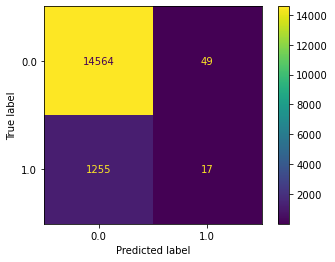

In [12]:
plot_confusion_matrix(clf_knn, X_test, Y_test)

In [23]:
# I tried several different algorithm parameters here (e.g. kd_tree, ball_tree) without effect
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean', algorithm='kd_tree')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 7 neighbors is: 0.250  AUC: 0.509


From the Confusion Matrix above, notice the large number of false positives. The model incorrectly classified over 1000 observations as wins when they should have been loses. It only correctly classified about 50 wins. Since this data set is results of horse races, you can assume an interested party would be a gambler. The KNN model would not be of much benefit to a gambler due to the large number of Type I error in proportion to true positive results.

#### Predict Show Horses

Next we generated several more KNN models where we predicted Show instead of Win. We tried several different metrics of measure and K values.

#### Euclidean distance for Show

In [24]:
# Use Euclidean distance
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
    clf_knn.fit(X_train_Show,Y_train_Show)
    yhat= clf_knn.predict(X_test_Show)
    acc = mt.accuracy_score(Y_test_Show,yhat)
    prec = mt.precision_score(Y_test_Show,yhat)
    auc = roc_auc_score(Y_test_Show,yhat)
    conf = mt.confusion_matrix(Y_test_Show,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.127  AUC: 0.510
Precision of classifier with 5 neighbors is: 0.113  AUC: 0.503
Precision of classifier with 7 neighbors is: 0.137  AUC: 0.503
Precision of classifier with 9 neighbors is: 0.180  AUC: 0.502
Precision of classifier with 11 neighbors is: 0.222  AUC: 0.502
Precision of classifier with 13 neighbors is: 0.240  AUC: 0.502
Precision of classifier with 15 neighbors is: 0.214  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.091  AUC: 0.500
Precision of classifier with 19 neighbors is: 0.167  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.250  AUC: 0.500


#### Manhattan distance for Show

In [25]:
# Use manhattan distance
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')
    clf_knn.fit(X_train_Show,Y_train_Show)
    yhat= clf_knn.predict(X_test_Show)
    acc = mt.accuracy_score(Y_test_Show,yhat)
    prec = mt.precision_score(Y_test_Show,yhat)
    auc = roc_auc_score(Y_test_Show,yhat)
    conf = mt.confusion_matrix(Y_test_Show,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.154  AUC: 0.515
Precision of classifier with 5 neighbors is: 0.180  AUC: 0.509
Precision of classifier with 7 neighbors is: 0.158  AUC: 0.503
Precision of classifier with 9 neighbors is: 0.164  AUC: 0.502
Precision of classifier with 11 neighbors is: 0.182  AUC: 0.501
Precision of classifier with 13 neighbors is: 0.238  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.182  AUC: 0.500
Precision of classifier with 17 neighbors is: 0.286  AUC: 0.501
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.501
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


#### Chebyshev distance for Show

In [29]:
# Use Chebyshev distance
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')
    clf_knn.fit(X_train_Show,Y_train_Show)
    yhat= clf_knn.predict(X_test_Show)
    acc = mt.accuracy_score(Y_test_Show,yhat)
    prec = mt.precision_score(Y_test_Show,yhat)
    auc = roc_auc_score(Y_test_Show,yhat)
    conf = mt.confusion_matrix(Y_test_Show,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.104  AUC: 0.505
Precision of classifier with 5 neighbors is: 0.115  AUC: 0.503
Precision of classifier with 7 neighbors is: 0.115  AUC: 0.501
Precision of classifier with 9 neighbors is: 0.180  AUC: 0.502
Precision of classifier with 11 neighbors is: 0.172  AUC: 0.501
Precision of classifier with 13 neighbors is: 0.118  AUC: 0.500
Precision of classifier with 15 neighbors is: 0.222  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.286  AUC: 0.501
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.501
Precision of classifier with 21 neighbors is: 0.333  AUC: 0.500


Across the different KNN models created to classify Show horses, the AUCs were all comparable to that of the KNN models for Win horses: slightly more than 0.5

However, the precision was lower almost across the board. If I had to select one model, it would be the Euclidean distance metric with a K value of 13, although there a better model choices than KNN as we will see in the following sections of this Lab. In fact, in the Mini Lab we generated several Logistic Regression and SVM with significantly higher AUCs and precisions.

### Sub-Section 5.1.2: Model 2 Naive Bayes

#### Model to predict Won

#### Model to predict Show

#### Gaussian Naive Bayes on the 'won' target response variable:

In [49]:
var = [.25,.5,.75,.95,1,1.2,1.4,1.6,2]
for x in var:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', GaussianNB(var_smoothing=x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When x = 0.25
   Mean Precision:  0.10124209461011588
   Mean AUC:  0.7060093520803179
   Mean Accuracy:  0.32394082467736857
   Mean Time per Split:  0.13398447036743164
 
When x = 0.5
   Mean Precision:  0.10456674092985299
   Mean AUC:  0.7064824462753292
   Mean Accuracy:  0.35537928863707896
   Mean Time per Split:  0.13404397964477538
 
When x = 0.75
   Mean Precision:  0.11385347414872307
   Mean AUC:  0.7071005769610672
   Mean Accuracy:  0.4377148253068933
   Mean Time per Split:  0.1379338026046753
 
When x = 0.95
   Mean Precision:  0.12987511752332276
   Mean AUC:  0.7076782454840116
   Mean Accuracy:  0.5512810827824992
   Mean Time per Split:  0.13377082347869873
 
When x = 1
   Mean Precision:  0.13464804507961875
   Mean AUC:  0.7078198496040616
   Mean Accuracy:  0.584734025810513
   Mean Time per Split:  0.13500802516937255
 
When x = 1.2
   Mean Precision:  0.14926277220143597
   Mean AUC:  0.7083777281966992
   Mean Accuracy:  0.7127730563424615
   Mean Time per Spl

#### Complement Naive Bayes on the 'Won' target response variable:

In [50]:
var2 = [.05,.25,1,3,5,6]
for x in var2:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', ComplementNB(alpha = x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When x = 0.05
   Mean Precision:  0.13102338394721938
   Mean AUC:  0.746677728799247
   Mean Accuracy:  0.5421466792571608
   Mean Time per Split:  0.08911499977111817
 
When x = 0.25
   Mean Precision:  0.13109039000011966
   Mean AUC:  0.746798216845774
   Mean Accuracy:  0.5424425558703179
   Mean Time per Split:  0.09674279689788819
 
When x = 1
   Mean Precision:  0.13144789182233368
   Mean AUC:  0.7473594417308272
   Mean Accuracy:  0.5436701290525653
   Mean Time per Split:  0.09404971599578857
 
When x = 3
   Mean Precision:  0.1322228259228747
   Mean AUC:  0.7480043669654013
   Mean Accuracy:  0.5469499527856468
   Mean Time per Split:  0.0965937852859497
 
When x = 5
   Mean Precision:  0.13288069143564354
   Mean AUC:  0.7480641536979006
   Mean Accuracy:  0.5504060434372049
   Mean Time per Split:  0.0971142292022705
 
When x = 6
   Mean Precision:  0.13324284248439383
   Mean AUC:  0.7480613938136415
   Mean Accuracy:  0.5524457034938621
   Mean Time per Split:  0.10006

#### Gaussian Naive Bayes on the 'show' target response variable:

In [51]:
var3 = [.25,.5,.75,.95,1,1.2,1.4,1.6,2]
for x in var3:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', GaussianNB(var_smoothing=x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When x = 0.25
   Mean Precision:  0.28051887901406747
   Mean AUC:  0.7047869038500877
   Mean Accuracy:  0.40098205854579794
   Mean Time per Split:  0.12684803009033202
 
When x = 0.5
   Mean Precision:  0.27802573761487837
   Mean AUC:  0.7065664399389135
   Mean Accuracy:  0.3925023607176582
   Mean Time per Split:  0.13014957904815672
 
When x = 0.75
   Mean Precision:  0.2771895067236395
   Mean AUC:  0.7078383347523913
   Mean Accuracy:  0.3893862134088763
   Mean Time per Split:  0.13380558490753175
 
When x = 0.95
   Mean Precision:  0.27722924657979336
   Mean AUC:  0.7086980347133042
   Mean Accuracy:  0.38919735599622285
   Mean Time per Split:  0.13051867485046387
 
When x = 1
   Mean Precision:  0.27729988516412574
   Mean AUC:  0.7088968244905948
   Mean Accuracy:  0.3893862134088763
   Mean Time per Split:  0.13451504707336426
 
When x = 1.2
   Mean Precision:  0.2778487207681709
   Mean AUC:  0.7096466191486451
   Mean Accuracy:  0.39102927289896133
   Mean Time per Sp

#### Complement Naive Bayes on the 'show' target response variable:

In [52]:
var4 = [.001,1,5,20,30,50]
for x in var4:
    # define the pipeline
    steps = list()
    steps.append(('scaler', MinMaxScaler()))
    steps.append(('model', ComplementNB(alpha = x)))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When x =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When x = 0.001
   Mean Precision:  0.34871056495033725
   Mean AUC:  0.7419934128075327
   Mean Accuracy:  0.5864463330185711
   Mean Time per Split:  0.08118259906768799
 
When x = 1
   Mean Precision:  0.34888837823463803
   Mean AUC:  0.742215117807883
   Mean Accuracy:  0.5867170286433742
   Mean Time per Split:  0.08926074504852294
 
When x = 5
   Mean Precision:  0.34963042114635734
   Mean AUC:  0.7427586265778003
   Mean Accuracy:  0.5877368586717029
   Mean Time per Split:  0.08557250499725341
 
When x = 20
   Mean Precision:  0.352164140948355
   Mean AUC:  0.7433323022786439
   Mean Accuracy:  0.5917406358199558
   Mean Time per Split:  0.08598225116729737
 
When x = 30
   Mean Precision:  0.35407885653796833
   Mean AUC:  0.7429834664536602
   Mean Accuracy:  0.5954674220963173
   Mean Time per Split:  0.09003214836120606
 
When x = 50
   Mean Precision:  0.3583065324313309
   Mean AUC:  0.7418565558306772
   Mean Accuracy:  0.6043500157381178
   Mean Time per Split:  0.084

Next we will want to look at the feature importance using the Gaussian Naive Bayes model using the 'Won' feature to see if there are any features that could be left out to try to remove noise from the model.

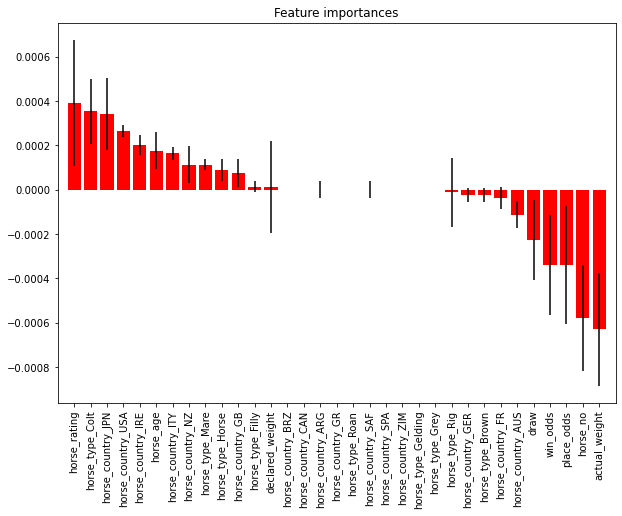

In [59]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(GNBmodel, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

#### trying out a grid search:


nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0),   # use any cross validation technique 
                 verbose=1, 
                 scoring='precision') 
gs_NB.fit(X_train_Show, Y_train_Show)

gs_NB.best_params_

## Using SMOTE sampling technique on the imbalanced classes

Resampled dataset shape Counter({0.0: 73063, 1.0: 73063})
Total Records 146126
Total Classes: 2
Class Gini Index 0.1473302877562952
Smallest Class Id: 1.0 Records: 73063
Largest Class Id: 1.0 Records: 73063
Accuracy when Guessing: 50.0 %


D:\Users\Ryan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Users\Ryan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


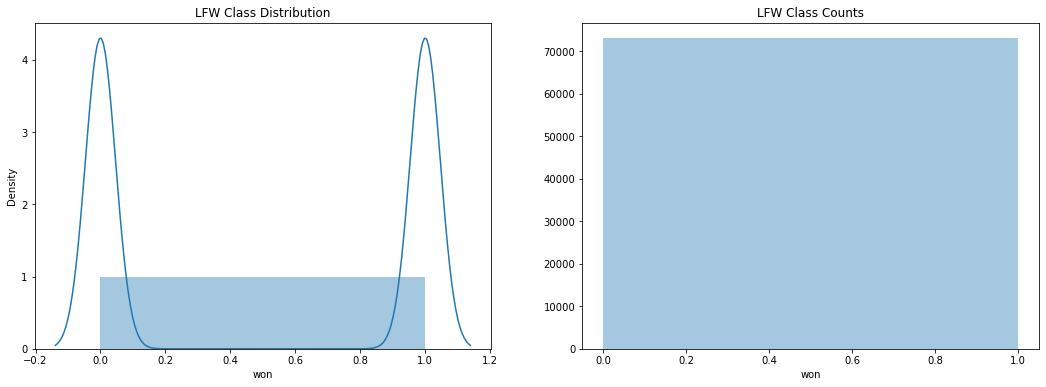

In [57]:
# Oversample using SMOTE
# Make all classes the same size as the majority class.
sm = SMOTE(sampling_strategy='not majority', random_state = 0)
X_sm, y_sm = sm.fit_resample(runs_data, runs_target)

print('Resampled dataset shape %s' % Counter(y_sm))
# Plot the new class distributions for y using the same funnction as above. 
def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_class_dist(y):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(runs_target))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('LFW Class Distribution');
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('LFW Class Counts');
plot_class_dist(y_sm)

In [58]:
import time
from sklearn.model_selection import cross_validate

def stratified_cross_validate(model, X, y, cv=cv):
    start = time.time()
    cv_results = cross_validate(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_score'])
    print(' ')
    print('Mean Accuracy: ', cv_results['test_score'].mean())
    print('Mean Fit Time: ', cv_results['fit_time'].mean())
    print('Mean Score Time: ', cv_results['score_time'].mean())
    print('CV Time: ', elapsed_time)
    return

GNB = GaussianNB()
stratified_cross_validate(GNB, X_sm, y_sm)


Fold Scores:
 
[0.62091973 0.62396496 0.61996168 0.62290426 0.62420448 0.62529939
 0.62427291 0.61749812 0.63443509 0.61431602]
 
Mean Accuracy:  0.6227776637240813
Mean Fit Time:  0.34114053249359133
Mean Score Time:  0.06808180809020996
CV Time:  3.497809886932373


### Sub-Section 5.1.3: Model 3 Random Forest

#### Model to predict Won

#### Model to predict Show

#### Task 1
The first parameter we want to look at is the performance of forest size to find an optimal number of trees based on the initial data. Determining the correct size of the forest can help keep us from overfitting the model or by wasting resources with building an unneccessarily large forest.

In [13]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.1734869680040867
   Mean AUC:  0.779495550184272
   Mean Accuracy:  0.7048914069877242
   Mean Time per Split:  1.3461232900619506
 
When Trees = 75
   Mean Precision:  0.17267797155769868
   Mean AUC:  0.7792468539471402
   Mean Accuracy:  0.7032924142272584
   Mean Time per Split:  1.493518304824829
 
When Trees = 100
   Mean Precision:  0.17230177132421776
   Mean AUC:  0.779104063561049
   Mean Accuracy:  0.7024866225999371
   Mean Time per Split:  2.080084443092346
 
When Trees = 128
   Mean Precision:  0.1726826314093994
   Mean AUC:  0.7792232873331104
   Mean Accuracy:  0.7031224425558703
   Mean Time per Split:  3.1300196409225465
 


Looking at this information we are aiming for the best precision in our models as we want the best possible number of positive results while limiting false positives. So from this we would look at building a forest with 64 trees. This is also nice because it is the least time consuming. Next we will use this to run a loop to fine the optimal max_depth. This is the metric that determines the overall size of each individual tree by limiting the number of levels it can break down the data into. We will be looking at four levels in this loop, 5,20,100, and no limit(none)

In [14]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.1734869680040867
   Mean AUC:  0.779495550184272
   Mean Accuracy:  0.7048914069877242
   Mean Time per Split:  1.3078219652175904
 
When Depth = 20
   Mean Precision:  0.2423909931834415
   Mean AUC:  0.7571059326428996
   Mean Accuracy:  0.8686181932640856
   Mean Time per Split:  3.3543713331222533
 
When Depth = 100
   Mean Precision:  0.411532449426676
   Mean AUC:  0.743830897426131
   Mean Accuracy:  0.9191690273843249
   Mean Time per Split:  4.569573187828064
 
When Depth = None
   Mean Precision:  0.411532449426676
   Mean AUC:  0.743830897426131
   Mean Accuracy:  0.9191690273843249
   Mean Time per Split:  4.567449760437012
 


After assessing these results we wanted to take a look at feature importance on the selected model above. The reason for this is we want to try to eliminate noise variables. This has a secondary side effect with random forests of letting them run faster since the number of features is reduces. There were two ways we went about doing this for random forest. The first was a manual look at the feature importance, and selecting what we deemed to be the most important. The second way was to use recursive feature elimination with cross-validation to look at removing variables. 

In [15]:
#run best model with normal train test split for feature selection
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target):
    # note that these are sparse matrices
    X_train, X_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    Y_train, Y_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

clf_rf = RandomForestClassifier(max_depth = 100, n_estimators = 64, random_state = 0, class_weight = 'balanced')
clf_rf.fit(X_train,Y_train.values.ravel())
yhat = clf_rf.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)

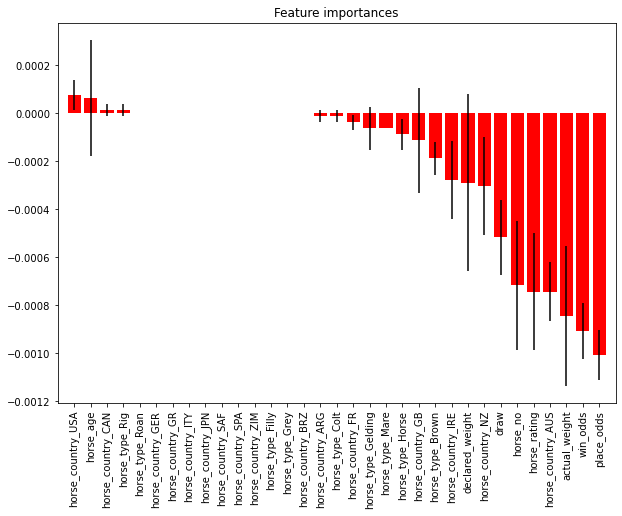

In [16]:
features = list(runs_data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(clf_rf, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []
for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(33)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

Just by looking at this graph we can make some simple eliminations of features that did not help in this model. Likely we would want to keep the first three factors and the last 15 factors in the model and eliminate the rest. This has been done in the data below.

In [29]:
optfeatures = featureorder[:3]
optfeatures2 = featureorder[-15:]
optfeatures = optfeatures + optfeatures2
dataopt = runs_data[optfeatures]

Optimal number of features : 27


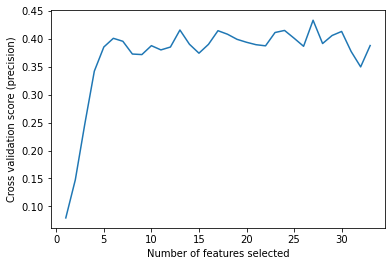

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 6.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 3.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected False, Rank: 7.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected True, Rank: 1.000
Column: 25, Selected True, Rank:

In [23]:
#Recursive Feature Elimination
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf, step=1, cv=StratifiedKFold(2),
              scoring='precision',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (precision)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

In [36]:
#dropping features from dataset not selected by recursive feature elimination
dataopt2 = runs_data.drop(runs_data.columns[[10,15,21,26,28,32]],axis = 1)

After building out these new datasets we decided to run the same crossvalidated pieces against them. You can see the results of these below. The first two loops are run on the manually optimized data.

In [25]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.17502974555137368
   Mean AUC:  0.7817228682395747
   Mean Accuracy:  0.7086559647466163
   Mean Time per Split:  1.4422401666641236
 
When Trees = 75
   Mean Precision:  0.17514281765547052
   Mean AUC:  0.7820247366327991
   Mean Accuracy:  0.7089266603714197
   Mean Time per Split:  1.5971493005752564
 
When Trees = 100
   Mean Precision:  0.1745749479689083
   Mean AUC:  0.7823204423604897
   Mean Accuracy:  0.7073402581051307
   Mean Time per Split:  2.1995540380477907
 
When Trees = 128
   Mean Precision:  0.17449478656796066
   Mean AUC:  0.7825397213517558
   Mean Accuracy:  0.7070632672332389
   Mean Time per Split:  3.146713376045227
 


With the set of manually optimized data we see that 75 trees has the greatest precision. We are also seeing increased scores for AUC and Precision. There is a jump here from .7794 to .782 and .1734 to .1751 respectively. The model, however, does take slightly longer to run with the larger forest size, but not substantially longer.

In [28]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 75, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.17514281765547052
   Mean AUC:  0.7820247366327991
   Mean Accuracy:  0.7089266603714197
   Mean Time per Split:  2.212781381607056
 
When Depth = 20
   Mean Precision:  0.2647281547409137
   Mean AUC:  0.7565371920496397
   Mean Accuracy:  0.8914384639597104
   Mean Time per Split:  4.18995771408081
 
When Depth = 100
   Mean Precision:  0.42195083023271074
   Mean AUC:  0.7477202414538273
   Mean Accuracy:  0.9192193893610323
   Mean Time per Split:  4.450371336936951
 
When Depth = None
   Mean Precision:  0.42195083023271074
   Mean AUC:  0.7477202414538273
   Mean Accuracy:  0.9192193893610323
   Mean Time per Split:  5.558593606948852
 


Looking at the results from max_depth, we would want to select a depth max of 100 like in the last model. This is because the difference between precision and AUC is none existant between limiting depth to 100 and no limit. So the runtime benefit here is the deciding factor. Next we will run this again but with the recursive feature elimination dataset to see if there is a difference between the two.

In [37]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = 5, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.1730702735001001
   Mean AUC:  0.7802588276485098
   Mean Accuracy:  0.7040415486307838
   Mean Time per Split:  1.9027633905410768
 
When Trees = 75
   Mean Precision:  0.17323627788588594
   Mean AUC:  0.7804423868512013
   Mean Accuracy:  0.7042367012905256
   Mean Time per Split:  2.1372162818908693
 
When Trees = 100
   Mean Precision:  0.1733110931719378
   Mean AUC:  0.7804241543994385
   Mean Accuracy:  0.7042933585143217
   Mean Time per Split:  2.5688361883163453
 
When Trees = 128
   Mean Precision:  0.1738546350043419
   Mean AUC:  0.7803952643829243
   Mean Accuracy:  0.7054894554611268
   Mean Time per Split:  2.8687442779541015
 


Just based on this first run. It doesnt look like the recursive feature elimination will beat out the manual feature selection but for the sake of being thorough we went ahead and ran the loop to look at depth with a forest size of 128 trees.

In [39]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 75, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.17323627788588594
   Mean AUC:  0.7804423868512013
   Mean Accuracy:  0.7042367012905256
   Mean Time per Split:  1.5568844318389892
 
When Depth = 20
   Mean Precision:  0.2510934104620996
   Mean AUC:  0.7586044798570413
   Mean Accuracy:  0.8775889203651243
   Mean Time per Split:  4.307234549522399
 
When Depth = 100
   Mean Precision:  0.4277345654895962
   Mean AUC:  0.7491292296167753
   Mean Accuracy:  0.919257160843563
   Mean Time per Split:  5.736360001564026
 
When Depth = None
   Mean Precision:  0.4277345654895962
   Mean AUC:  0.7491292296167753
   Mean Accuracy:  0.919257160843563
   Mean Time per Split:  4.830922198295593
 


The results of this loop were surprising as originally it looked as though the RFE dataset would be coming back with lower stats than the manually selected features. However, once the loop for max depth was run there was a jump in statistics from precision .4219 and AUC .7477 to precision .4277 and AUC .7491 at a max depth of 100. This means that our best model for runtime efficiency, precision and AUC would be a Random Forest with weight classed balance, a max depth of 100 and forest size of 75.

#### Task 2
Now that we have a best model for the wins of task one we need to move to task two of trying to classify horses that place instead of just the winners from each race. In theory the statistics for these models should all be better due to the fact that the number of posible successes is higher proportionally.

In [40]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.40832228777768337
   Mean AUC:  0.763572257772536
   Mean Accuracy:  0.6815738117721121
   Mean Time per Split:  1.3178723096847533
 
When Depth = 20
   Mean Precision:  0.462018838753038
   Mean AUC:  0.7552820284343419
   Mean Accuracy:  0.7389864652187599
   Mean Time per Split:  4.223642659187317
 
When Depth = 100
   Mean Precision:  0.5641607123461814
   Mean AUC:  0.7453712835323056
   Mean Accuracy:  0.7729619137551149
   Mean Time per Split:  5.2573548555374146
 
When Depth = None
   Mean Precision:  0.5641607123461814
   Mean AUC:  0.7453712835323056
   Mean Accuracy:  0.7729619137551149
   Mean Time per Split:  5.0395427942276
 


In this first run of the data running a with no max depth interestingly seems to be comparable statistics wise with running a model with max depth 100, and strangly it ran faster than the max depth 100. So we will now run the loop again to tune forest size using this max depth.

In [41]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = None, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.5641607123461814
   Mean AUC:  0.7453712835323056
   Mean Accuracy:  0.7729619137551149
   Mean Time per Split:  5.031184101104737
 
When Trees = 75
   Mean Precision:  0.5613684458360388
   Mean AUC:  0.7468433367797412
   Mean Accuracy:  0.7729682090022033
   Mean Time per Split:  6.57167546749115
 
When Trees = 100
   Mean Precision:  0.5680501288418924
   Mean AUC:  0.7484485961666838
   Mean Accuracy:  0.7737236386528171
   Mean Time per Split:  8.309428763389587
 
When Trees = 128
   Mean Precision:  0.5694091542863441
   Mean AUC:  0.7495457917326881
   Mean Accuracy:  0.7739943342776204
   Mean Time per Split:  9.770753026008606
 


After running the second loop our best metrics can be found with a forest size of 128 trees. Now that we have these base statistics. We will want to again optimize the data set using RFE. We decided not to attempt to beat the machine this time and instead utilize RFE to expidite model build.

In [44]:
#run best model with normal train test split for feature selection
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target2):
    # note that these are sparse matrices
    X_train, X_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    Y_train, Y_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

mmscl_obj = MinMaxScaler()
X_train = mmscl_obj.fit_transform(X_train,y = None)
X_test = mmscl_obj.transform(X_test)

clf_rf = RandomForestClassifier(max_depth = None, n_estimators = 128, random_state = 0, class_weight = 'balanced')
clf_rf.fit(X_train,Y_train.values.ravel())
yhat = clf_rf.predict(X_test)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)

Optimal number of features : 17


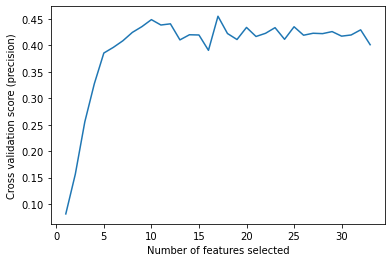

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 7.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 15.000
Column: 11, Selected False, Rank: 10.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 3.000
Column: 15, Selected False, Rank: 16.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 11.000
Column: 18, Selected False, Rank: 8.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected False, Rank: 2.000
Column: 21, Selected False, Rank: 17.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected False, Rank: 9.000
Column: 24, Selected True, Rank: 1.000
Column: 25, Selected

In [45]:
#Recursive Feature Elimination
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=clf_rf, step=1, cv=StratifiedKFold(2),
              scoring='precision',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (precision)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

In [52]:
#dropping features from dataset not selected by recursive feature elimination
dataopt2 = runs_data.drop(runs_data.columns[[8,10,11,14,15,17,18,20,21,23,25,26,28,30,31,32]],axis = 1)


With this data set because the number of possible successes goes up, it is not surprising that a smaller number of features is needed to predict this success. We see all the same features eliminated that were eliminated when predicting a winner, but more are added to the list as they are less important in predicting a top 3 placing. Now that we have the optimized dataset for place. We will run the loops again to look for improved performace of both metrics and speed.

In [47]:
depth = [5,20,100,None]
for x in depth:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = x, n_estimators = 64, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Depth =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Depth = 5
   Mean Precision:  0.40872383455698663
   Mean AUC:  0.76655368731748
   Mean Accuracy:  0.6820585457979226
   Mean Time per Split:  1.6218015909194945
 
When Depth = 20
   Mean Precision:  0.4792458303045805
   Mean AUC:  0.7511754360192546
   Mean Accuracy:  0.7504312244255587
   Mean Time per Split:  5.231083798408508
 
When Depth = 100
   Mean Precision:  0.5606525162496617
   Mean AUC:  0.7438935308074622
   Mean Accuracy:  0.7721435316336166
   Mean Time per Split:  4.947867965698243
 
When Depth = None
   Mean Precision:  0.5606525162496617
   Mean AUC:  0.7438935308074622
   Mean Accuracy:  0.7721435316336166
   Mean Time per Split:  5.120067501068116
 


It is interesting looking at this data where the depth 5 statistics beat the original non-optimized model, however as depth increased. The optimized model didnt seem to keep pace with the original model.  This might be a similar situation to the last attempt at optimization though where the final model did manage to beat out the original model. From this we will use max depth None to try to optimize our final model. The reason for chosing None of 100 even though 100 had a better calculation speed was to try to compare like for like models here. 

In [49]:
trees = [64,75,100,128]
for x in trees:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', RandomForestClassifier(max_depth = None, n_estimators = x, random_state = 0, class_weight = 'balanced')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, dataopt2, runs_target2, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When Trees =',x)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When Trees = 64
   Mean Precision:  0.5606525162496617
   Mean AUC:  0.7438935308074622
   Mean Accuracy:  0.7721435316336166
   Mean Time per Split:  5.873494076728821
 
When Trees = 75
   Mean Precision:  0.5609534169962382
   Mean AUC:  0.7452121163655361
   Mean Accuracy:  0.7727101038715769
   Mean Time per Split:  5.793795871734619
 
When Trees = 100
   Mean Precision:  0.5662260630052532
   Mean AUC:  0.7474496560283374
   Mean Accuracy:  0.7731948378973874
   Mean Time per Split:  8.358948016166687
 
When Trees = 128
   Mean Precision:  0.5682914131911885
   Mean AUC:  0.7486290502895729
   Mean Accuracy:  0.773553666981429
   Mean Time per Split:  10.528191709518433
 


The final optimized model would have been with a max_depth of None and a forest size of x. Interestingly the optimized model here did not perform better than the full model. This could be because the algorithm for it is trying to balance bias and variability and this time the metrics just didn't increase the precision, but may have made it more adaptable to another data set. However, just based on metrics alone, the full model should be deployed in this case. To compare these to the other types of models we are going to use AUC as it is an easy statistical measure of the predictive power of each model. 

### Sub-Section 5.1.4: Model 4 Logistic Regression

#### Model to predict Won

#### Model to predict Show

## Section 6: Modeling and Evaluation 4

	• Modeling and Evaluation 4
		○ Analyze the results using your chosen method of evaluation. 
            - Use visualizations of the results to bolster the analysis. 
            - Explain any visuals and analyze why they are interesting to someone that might use this model.

### Sub-Section 6.1: Analyze the results using your chosen method of evaluation.

#### Models to Predict Won

#### Models to Predict Show

## Section 7: Modeling and Evaluation 5

	• Modeling and Evaluation 5
		○ Discuss the advantages of each model for each classification task, if any. 
			- If there are not advantages, explain why. 
		○ Is any model better than another? 
		○ Is the difference significant with 95% confidence? 
			- Use proper statistical comparison methods. You must use statistical comparison techniques—be sure 
            they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

### Sub-Section 7.1: Discuss the advantages of each model for each classification task, if any.

### Sub-Section 7.2: Is any model better than another? 

### Sub-Section 7.3: Is the difference significant with 95% confidence? 

## Section 8: Modeling and Evaluation 6

	• Modeling and Evaluation 6
		○ Which attributes from your analysis are most important? 
            - Use proper methods discussed in class to evaluate the importance of different attributes. 
		○ Discuss the results and hypothesize about why certain attributes are more important than others for a
        given classification task.

### Sub-Section 8.1: Which attributes from your analysis are most important? 

### Sub-Section 8.1.1: Model 1 KNN

#### Model to predict Won

#### Model to predict Show

### Sub-Section 8.1.2: Model 2 Naive Bayes

#### Model to predict Won

#### Model to predict Show

### Sub-Section 8.1.3: Model 3 Random Forest

#### Model to predict Won

#### Model to predict Show

### Sub-Section 8.1.4: Model 4 Logistic Regression

#### Model to predict Won

#### Model to predict Show

## Section 9: Deployment

	• Deployment
		○ How useful is your model for interested parties (i.e., the companies or organizations that might want
        to use it for prediction)? 
		○ How would you measure the model's value if it was used by these parties? 
		○ How would your deploy your model for interested parties? 
		○ What other data should be collected? 
		○ How often would the model need to be updated, etc.? 

### Sub-Section 9.1: How useful is your model for interested parties

### Sub-Section 9.2: How would you measure the model's value if it was used by these parties? 

### Sub-Section 9.3: How would your deploy your model for interested parties? 

### Sub-Section 9.4: What other data should be collected?

### Sub-Section 9.5: How often would the model need to be updated? 

## Section 10: Exceptional Work

	• Exceptional Work
		○ You have free reign to provide additional analyses. 
			- One idea: grid search parameters in a parallelized fashion and visualize the performances across
            attributes. 
			- Which parameters are most significant for making a good model for each classification algorithm?

### Sub-Section 10.1: Recursive Feature Selection

### Sub-Section 10.2: Grid Search

### Sub-Section 10.3: Extra Model to predict Won and Show

# Line break between reports
=========================================

## Example on how to scale, model, and get metrics while using cross validation with a pipeline
## Example also shows how to use this to tune a tune a hyper-parameter

#### Possible adjustments you should look at
- The parameter being hypertuned and values at the start of the loop
- Is the scaler type what you want
- Is the model information updated
- The cross_validate() function uses runs_data and runs_target to check for win. You need to unpdate to runs_target2 to check for show
- You should also update the first print statement to reflect your hyperparameter name
- This should be applied to all models so we are consistent because original method was not fully utilizing all splits

In [ ]:
#Referenced website: https://machinelearningmastery.com/data-preparation-without-data-leakage/
Kvals = [5,10]
for k in Kvals:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    #steps.append(('model', KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')))
    steps.append(('model', KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    #cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)
    cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state = 0)

    
    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When k =',k)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')